In [1]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
#from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import train_test_split
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Initialise the data

In [5]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

np.random.shuffle(train_all)
np.random.shuffle(test_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

<PIL.Image.Image image mode=RGB size=64x64 at 0x7F3421917450>
[0.0, 1.0]


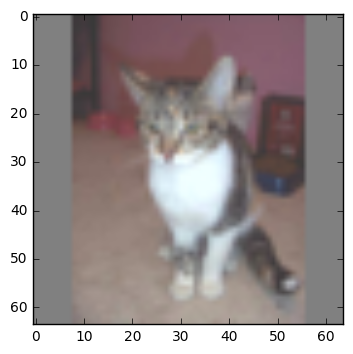

In [11]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print (processed_image)

print (labels[random_index])
plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [12]:
print (np.array(processed_image).shape)

(64, 64, 3)


In [13]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [14]:
from multiprocessing import Pool

In [15]:
dataset_size = 500
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print train[0].shape
print len(train), len(labels)

(64, 64, 3)
500 500


In [45]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, is_training, step=1e-4, size=64, batch_size=100):
        self.weight_decay = 0
        self.bn_params = {
            # Decay for the moving averages.
            'decay': 0.999,
            'center': True,
            'scale': True,
            # epsilon to prevent 0s in variance.
            'epsilon': 0.002,
            # None to force the updates during train_op
            'updates_collections': None,
            'is_training': is_training
        }

        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        with tf.contrib.framework.arg_scope(
                [layers.convolution2d],
                kernel_size=3, stride=1, padding='SAME', activation_fn=tf.nn.tanh,
                normalizer_fn=layers.batch_norm, normalizer_params=self.bn_params,
                #weights_initializer=layers.variance_scaling_initializer(),
                #weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)
              
            net = layers.convolution2d(self.X, num_outputs=36)
            net = layers.convolution2d(net, num_outputs=36)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=36)
  
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=64)
        

            net = layers.flatten(net, [-1, 16 * 16 * 64])
            net = layers.fully_connected(net, num_outputs=128, activation_fn=tf.nn.relu)
            net = layers.dropout(net, keep_prob=self.keep_prob)

            net = layers.fully_connected(net, num_outputs=self.class_num)
            self.y = layers.softmax(net)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.AdamOptimizer(step).minimize(self.loss)
        
        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, epochs=2000, keep_prob=0.5):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())
        
        batch_size = self.batch_size
        
        batch_start = 0
        batch_end = batch_start + batch_size
        
        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)
        
        for iteration in range(epochs):
            _, loss, probs = self.sess.run(
                [self.optimizer, self.loss, self.y],
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )
            
            if iteration % 100 == 0:
                train_acc = self.sess.run(
                    self.acc,
                    feed_dict={
                        self.X: X_train[batch_start:batch_end],
                        self.y_: y_train[batch_start:batch_end],
                        self.keep_prob: 1.0
                    }
                )

                val_acc = self.sess.run(
                    self.acc,
                    feed_dict={self.X: X_test, self.y_: y_test, self.keep_prob: 1.0}
                )

                print(
                    'Iteration: {}, minibatch loss: {:2.6}, train acc: {:.2%}, validation acc: {:.2%}'.format(
                        iteration, loss, train_acc, val_acc)
                )

                if val_acc >= 0.8:
                    print('Validation acc is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                batch_start = 0
                batch_end = batch_start + batch_size
                
                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")
    
    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = tf.argmax(self.y, 1)

        predictions = []
        for i in range(0, len(test_x)):
            
            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]
            
            if len(batch) == 0:
                break
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})

            predictions.extend(list(predict_batch[0]))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d'
        )

        print('saved: %s' % file_name)

In [46]:
class_num = 2
feature_number = image_size * image_size * 3

conv_net = TFConvNet(feature_number, class_num, False, size=image_size,  batch_size=50, step=5e-5) 

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.3)
conv_net.train(train_x, train_y, test_x, test_y, epochs=5000, keep_prob=1.0)

Starting to train
Iteration: 0, minibatch loss: 0.690202, train acc: 68.00%, validation acc: 51.33%
Iteration: 100, minibatch loss: 0.561721, train acc: 76.00%, validation acc: 70.67%


In [ ]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [ ]:
print test[0].shape

In [ ]:
conv_net.generate_submission(test)